In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
july16_users  = pd.read_csv('../data/cleaned_lichess_data/july16_users.csv')
aug16_users  = pd.read_csv('../data/cleaned_lichess_data/aug16_users.csv')
july18_users  = pd.read_csv('../data/cleaned_lichess_data/july18_users.csv')


In [3]:
july16_users.head()

,username,total_count,earliest,latest,career_length,play_freq,percent_rapid,percent_Blitz,percent_bullet,percent_classic,percent_puzzle
0,BestbyPractice,182,2016-07-01,2024-05-03,2864,0.063547,0.104396,0.818681,0.000000,0.208791,0.000000
1,DogeArmyYT,2,2016-07-01,2016-07-02,2,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000
2,Doovd,176,2016-07-01,2024-01-03,2743,0.064163,0.250000,0.130682,0.039773,0.596591,0.267045
3,GnosticPopsicle,49,2016-07-01,2021-05-22,1787,0.027420,0.204082,0.000000,0.000000,0.775510,0.020408
4,HighFriction,1,2016-07-01,2016-07-01,1,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000


## 1. Plots:
### 1.1 Total Unique Days: 

In [187]:
# Define thresholds
thr_years = 1.5 # threshold in years for rightmost bin for career length
thr_days = 300 # threshold in days for TUD
career_thr_yr = 4
career_thr = career_thr_yr*365 # career thresh in days 


# Function to bin the dataframe (to avoid repeating code)
def bin_dataframe(df, month_label):
    df_binned = df.copy()
    
    # Create binned columns using numpy's where (equivalent to R's if_else)
    df_binned['total_days_played'] = np.where(
        df_binned['total_count'] > thr_days,
        thr_days,
        df_binned['total_count']
    )
    
    df_binned['career_length'] = np.where(
        df_binned['career_length'] > career_thr,
        career_thr,
        df_binned['career_length']
    )
    
    # Add month identifier
    df_binned['month'] = month_label
    
    return df_binned

# Apply binning to each dataframe
july16_users_binned = bin_dataframe(july16_users, "July 2016")
aug16_users_binned = bin_dataframe(aug16_users, "Aug 2016")
july18_users_binned = bin_dataframe(july18_users, "July 2018")

# Combine all dataframes (equivalent to R's bind_rows)
combined_users = pd.concat(
    [july16_users_binned, aug16_users_binned, july18_users_binned],
    axis=0,
    ignore_index=True
)

In [188]:
combined_users.head()

,username,total_count,earliest,latest,career_length,play_freq,percent_rapid,percent_Blitz,percent_bullet,percent_classic,percent_puzzle,total_days_played,month
0,BestbyPractice,182,2016-07-01,2024-05-03,1460,0.063547,0.104396,0.818681,0.000000,0.208791,0.000000,182,July 2016
1,DogeArmyYT,2,2016-07-01,2016-07-02,2,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,2,July 2016
2,Doovd,176,2016-07-01,2024-01-03,1460,0.064163,0.250000,0.130682,0.039773,0.596591,0.267045,176,July 2016
3,GnosticPopsicle,49,2016-07-01,2021-05-22,1460,0.027420,0.204082,0.000000,0.000000,0.775510,0.020408,49,July 2016
4,HighFriction,1,2016-07-01,2016-07-01,1,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1,July 2016


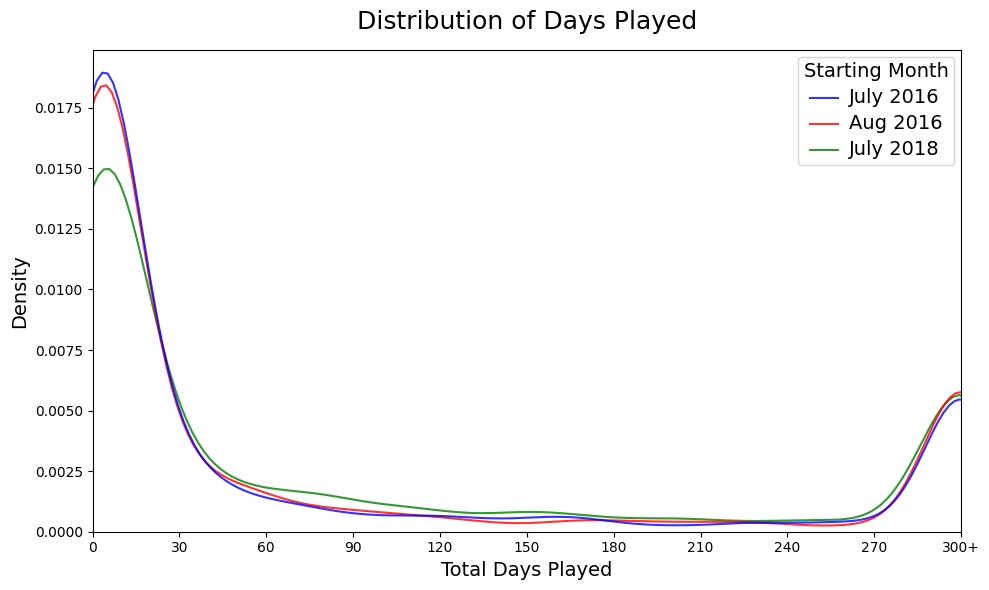

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the style and figure size
plt.style.use('default')
plt.figure(figsize=(10, 6))

# Create the KDE plot with hue
ax = sns.kdeplot(
    data=combined_users,
    x='total_days_played',
    hue='month',
    fill=False,
    alpha=.8,
    linewidth=1.5,
    #palette=['#2B2B2B', '#787878', '#CACACA'],  # Grayscale palette
    palette=['blue', 'red', 'green'],
    #palette = sns.color_palette("crest"),
    bw_adjust=0.5,  # Adjust bandwidth for smoother curves
    common_norm=False  # Ensure densities are comparable
)

# Customize the plot
plt.title('Distribution of Days Played', pad=15, fontsize=18)
plt.xlabel('Total Days Played', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Create custom x-axis ticks
x_ticks = np.arange(0, thr_days + 1, 30)
x_labels = [str(x) if x != thr_days else f'{thr_days}+' for x in x_ticks]
plt.xticks(x_ticks, x_labels)


# make sure to move legend to desired position first, and then change fontsizes:
sns.move_legend(ax,'upper right')
# set legend font-size:
plt.setp(ax.get_legend().get_texts(), fontsize=14) 
# set legend heading (title) fontsize:
plt.setp(ax.get_legend().get_title(), fontsize=14, text='Starting Month') 


# Set the axis limits
plt.xlim(0, thr_days)
plt.ylim(0, plt.ylim()[1])

# Adjust layout
plt.tight_layout()
plt.savefig('../plots/lichess_total_days_played.jpg', dpi=512)
plt.show()

### 1.2 Sigmoid and Concave total practice events distribution: 

In [190]:
import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_base import RPS_core  # Importing RPS_core class from rps_base.py
from rps_simulation.rps_multirun import RPS_multirun # Importing RPS_Multirun class, used for main plots

from rps_simulation.learning_curves import exponential_learning, logistic_learning # learonning curves
from rps_simulation.forgetting_curves import exponential_forgetting  # forgetting curves
from rps_simulation.practice_rate import simple_linear_rate  # simple linear rate
from rps_simulation.waiting_times import exponential_waiting_time  # exp waiting time distributi



In [191]:
### 1. Concave 
concave_sims = RPS_multirun(learning_func=exponential_learning(alpha=0.2),
                            forgetting_func= exponential_forgetting(forgetting_rate=0.2),
                            practice_rate_func=simple_linear_rate(a=0.2, b=5),
                            waiting_time_dist=exponential_waiting_time,
                            n_sims=200)
concave_sims.run_multiple_sims(interpolate_forgetting = False) # set to False to skip calculating interpolated skills 
                                  # when not practicing. Computationaly expensive but required if you want smooth plots. 
concave_colour = '#466be8'


### 2. Sigmoid
sigmoid_sims = RPS_multirun(learning_func=logistic_learning(alpha=0.4),
                            forgetting_func=exponential_forgetting(forgetting_rate=0.2),
                            practice_rate_func=simple_linear_rate(a=0.2, b=5),
                            waiting_time_dist=exponential_waiting_time,
                            n_sims=200)

# running the simulations
sigmoid_sims.run_multiple_sims(interpolate_forgetting=False) 
sigmoid_colour = '#f77150'



In [192]:
pn_con = concave_sims.total_practice_events
pn_sig = sigmoid_sims.total_practice_events

In [193]:
### ----- Plots ------

df_sim = pd.DataFrame.from_dict({
    'tot_prac': pn_con + pn_sig,
    'Learning Curve': ['Exponential' for i in range(len(pn_con))] + ['Logistic' for i in range(len(pn_sig))] 
})

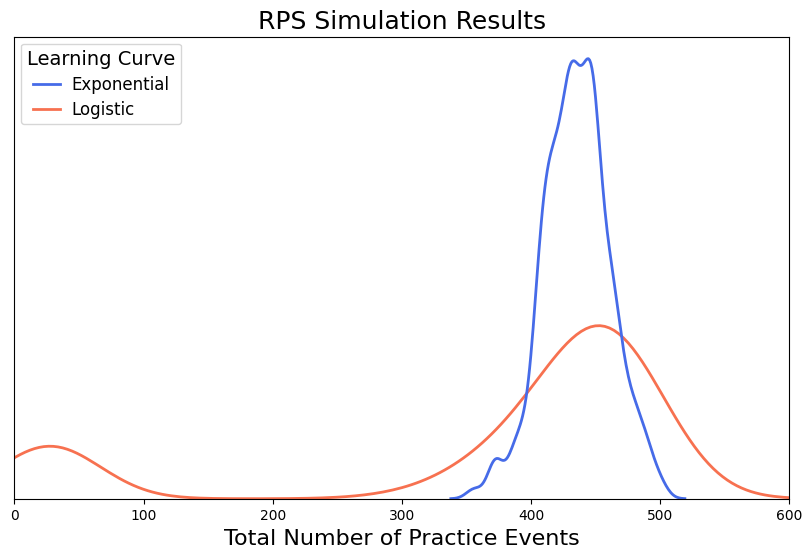

In [194]:
plt.figure(figsize=(10,6))
ax = sns.kdeplot(data=df_sim, x='tot_prac', 
            hue='Learning Curve', 
            fill=False,
            alpha=1,
            linewidth=2,
            bw_adjust=0.68,
            palette=[concave_colour, sigmoid_colour])


sns.move_legend(ax, 'upper left')
plt.setp(ax.get_legend().get_texts(), fontsize=12) # legend txt settings
plt.setp(ax.get_legend().get_title(), fontsize=14) # legend title settings

plt.xlabel('Total Number of Practice Events', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('RPS Simulation Results', fontsize=18)
plt.xlim([0, (max(pn_con + pn_sig)//100)*100 + 100])
plt.yticks([])

plt.savefig('../plots/rps_sim_tud_compare.jpg', dpi=512)
plt.show()

### 1.2 Career Length:

In [195]:
combined_users['career_len_yr'] = np.round(combined_users['career_length']/365, 2)
combined_users.head()

,username,total_count,earliest,latest,career_length,play_freq,percent_rapid,percent_Blitz,percent_bullet,percent_classic,percent_puzzle,total_days_played,month,career_len_yr
0,BestbyPractice,182,2016-07-01,2024-05-03,1460,0.063547,0.104396,0.818681,0.000000,0.208791,0.000000,182,July 2016,4.00
1,DogeArmyYT,2,2016-07-01,2016-07-02,2,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,2,July 2016,0.01
2,Doovd,176,2016-07-01,2024-01-03,1460,0.064163,0.250000,0.130682,0.039773,0.596591,0.267045,176,July 2016,4.00
3,GnosticPopsicle,49,2016-07-01,2021-05-22,1460,0.027420,0.204082,0.000000,0.000000,0.775510,0.020408,49,July 2016,4.00
4,HighFriction,1,2016-07-01,2016-07-01,1,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1,July 2016,0.00


In [196]:
career_thr_yr

4

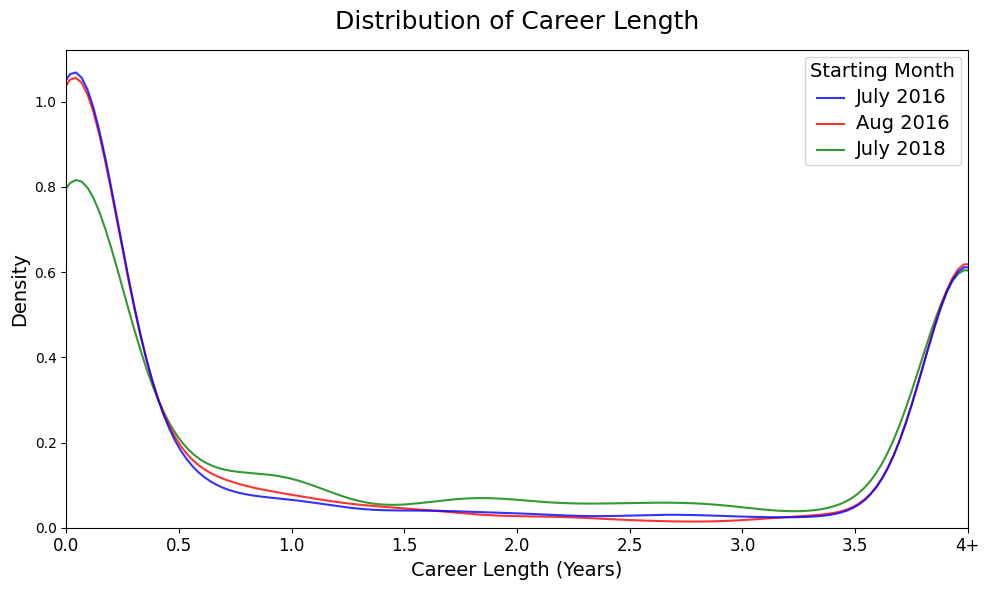

In [197]:
# Set the style and figure size
plt.style.use('default')
plt.figure(figsize=(10, 6))

# Create the KDE plot with hue
ax = sns.kdeplot(
    data=combined_users,
    x='career_len_yr',
    hue='month',
    fill=False,
    alpha=.8,
    linewidth=1.5,
    #palette=['#2B2B2B', '#787878', '#CACACA'],  # Grayscale palette
    palette=['blue', 'red', 'green'],
    bw_adjust=0.5,  # Adjust bandwidth for smoother curves
    common_norm=False  # Ensure densities are comparable
)

# Customize the plot
plt.title('Distribution of Career Length', pad=15, fontsize=18)
plt.xlabel('Career Length (Years)', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Create custom x-axis ticks
x_ticks = np.round(np.linspace(0, career_thr_yr, (career_thr_yr*2+1)),2)
x_labels = [str(x) if x != career_thr_yr else f'{career_thr_yr}+' for x in x_ticks]
plt.xticks(x_ticks, x_labels, fontsize=12)


# make sure to move legend to desired position first, and then change fontsizes:
sns.move_legend(ax,'upper right')
# set legend font-size:
plt.setp(ax.get_legend().get_texts(), fontsize=14) 
# set legend heading (title) fontsize:
plt.setp(ax.get_legend().get_title(), fontsize=14, text='Starting Month') 


# Set the axis limits
plt.xlim(0, career_thr_yr)
plt.ylim()

# Adjust layout
plt.tight_layout()
plt.savefig('../plots/lichess_career_length.jpg', dpi=512)
plt.show()